In [1]:
import sys
sys.path.append('../..') 
sys.path.append('..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm

In [2]:
path = "datasets/dog-breeds"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

datasets/dog-breeds/beagle
datasets/dog-breeds/bulldog
datasets/dog-breeds/dalmatian
datasets/dog-breeds/german-shepherd
datasets/dog-breeds/husky
datasets/dog-breeds/labrador-retriever
datasets/dog-breeds/poodle
datasets/dog-breeds/rottweiler


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(378, 224, 224, 3) Y_train:(378,) X_test:(163, 224, 224, 3) Y_test:(163,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(folder_path), activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [9]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 158ms/step - loss: 32.5886 - accuracy: 0.0625
0.12757353037595748


In [10]:
filterGeneticAlgorithm=FilterGeneticAlgorithm(X_train=X_train,Y_train=Y_train, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [11]:
best_filter= filterGeneticAlgorithm.run(generation_limit=3, population_size=24)

--------------------------------------------------------------------------------
2/2 [==============================] - 0s 7ms/step - loss: 3.5246 - accuracy: 0.1892
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.20362731367349624
--------------------------------------------------------------------------------
2/2 [==============================] - 0s 7ms/step - loss: 4.9339 - accuracy: 0.4865
filter [44, 103, 53, 117, 19, 198, 56, 31, 183, 7, 24, 1, 3, 160, 200, 1] fit: 0.5605974435806275
--------------------------------------------------------------------------------
2/2 [==============================] - 0s 7ms/step - loss: 4.4827 - accuracy: 0.3784
filter [7, 138, 18, 120, 8, 207, 195, 172, 79, 155, 16, 3, 2, 153, 104, 2] fit: 0.45206259191036224
--------------------------------------------------------------------------------
2/2 [==============================] - 0s 6ms/step - loss: 6.3489 - accuracy: 0.3243
filter [16, 95, 2, 181, 55, 231, 98, 183, 100, 

In [12]:
print(f"\nbest filter :{best_filter.filter} fit: {best_filter.fit}")


best filter :[59, 158, 34, 166, 21, 109, 72, 143, 114, 127, 11, 2, 1, 188, 265, 1] fit: 0.6108107984066009


In [13]:
filtered_X_train=np.array(filterGeneticAlgorithm.get_newData(X_train,filter=best_filter.filter))
filtered_X_test=np.array(filterGeneticAlgorithm.get_newData(X_test,filter=best_filter.filter))


print(f"X_train:{filtered_X_train.shape} Y_train:{Y_train.shape} X_test:{filtered_X_test.shape} Y_test:{Y_test.shape}")

X_train:(378, 224, 224, 3) Y_train:(378,) X_test:(163, 224, 224, 3) Y_test:(163,)


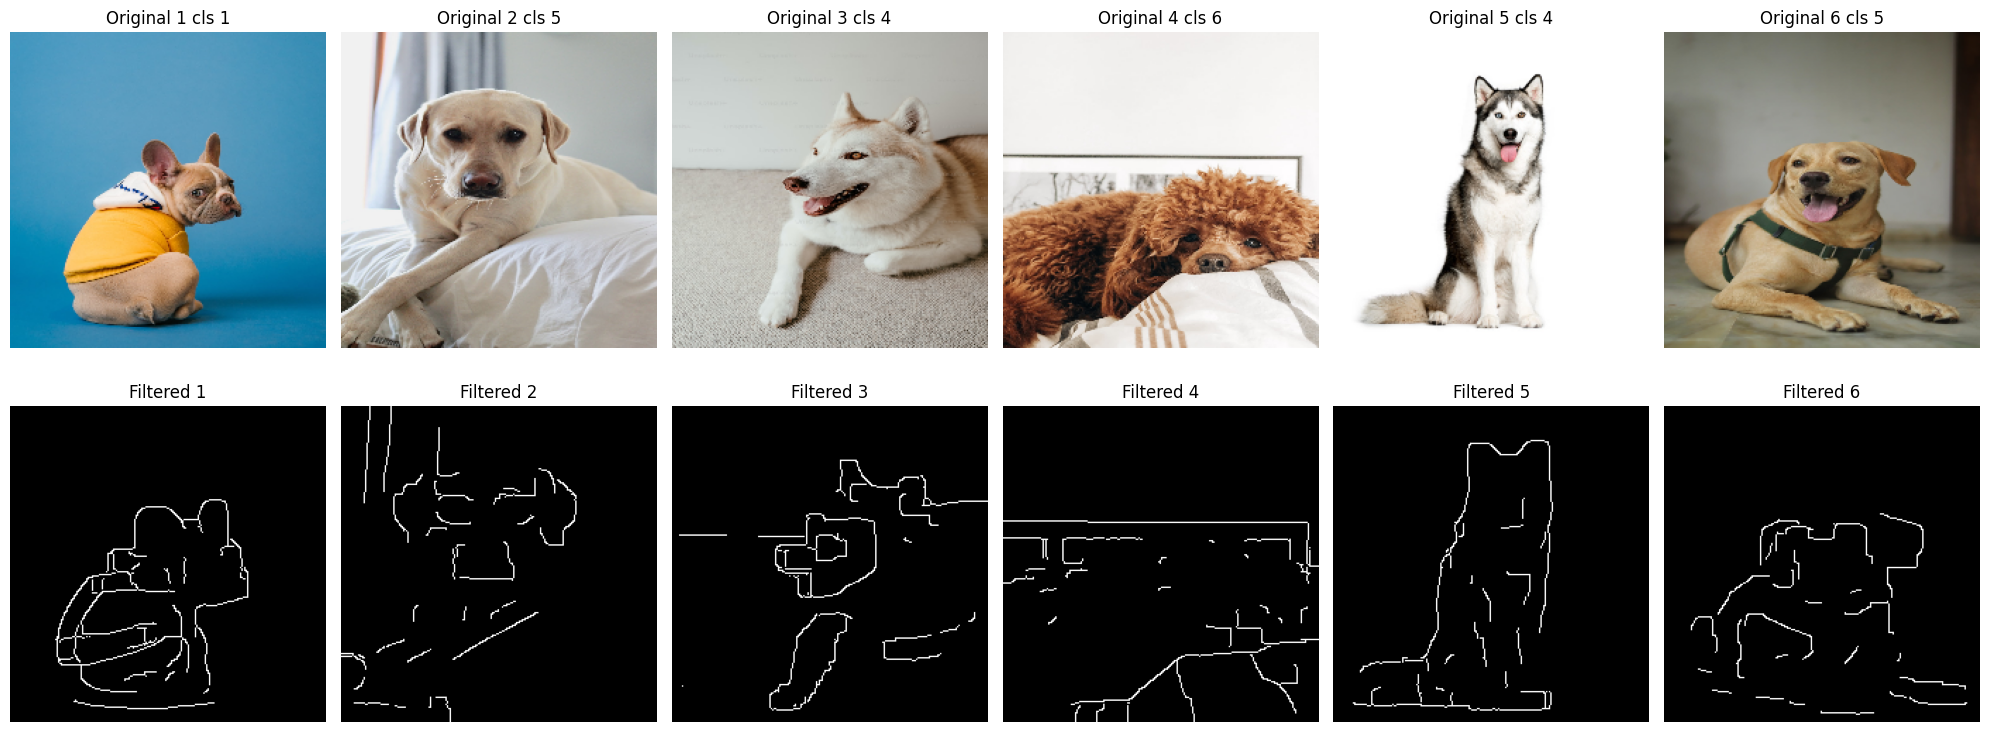

In [19]:
indices = np.random.randint(0, len(X_test), size=6)

fig, axes = plt.subplots(2, 6, figsize=(20, 8))

for i, ax_col in enumerate(axes.T):
    original_index = indices[i]
    
    ax_col[0].imshow(X_test[original_index])
    ax_col[0].set_title(f'Original {i+1} cls {Y_test[original_index]}')
    ax_col[0].axis('off')
    
    ax_col[1].imshow(filtered_X_test[original_index])
    ax_col[1].set_title(f'Filtered {i+1}')
    ax_col[1].axis('off')

plt.tight_layout()
plt.show()


In [15]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 168ms/step - loss: 4.0935 - accuracy: 0.5625
0.4312500014901161
